# Singapore COVID-19 Daily Cases with ARIMA

This project is inspired by Machine Learning Plus [ARIMA Model](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#arimapythonnotebook).

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

This public dataset is obtained through Singapore's official data website: [COVID-19 Case Numbers](https://data.gov.sg/dataset/covid-19-case-numbers). The data are from 23rd Jan 2020 to 22nd Dec 2022.

## Exploratory Data Analysis

In [4]:
df = pd.read_csv('Singapore_C19_Time_Series.csv')
df

,date,type,value
0,2020-01-23,Imported,1
1,2020-01-23,Local,0
2,2020-01-24,Imported,2
3,2020-01-24,Local,0
4,2020-01-25,Imported,1
...,...,...,...
2125,2022-12-20,Local,1220
2126,2022-12-21,Imported,239
2127,2022-12-21,Local,854
2128,2022-12-22,Imported,288


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2130 entries, 0 to 2129
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    2130 non-null   object
 1   type    2130 non-null   object
 2   value   2130 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 50.0+ KB


We can see the 'date' column is not in datetime format. Let's change it to its actual data type.

In [6]:
df['date'] = pd.to_datetime(df['date'])

We see that there are two different type of cases: imported and local. Let's view each of them separately for the final 60 days.

In [7]:
importedDF = df[df['type'] == 'Imported']
localDF = df[df['type'] == 'Local']

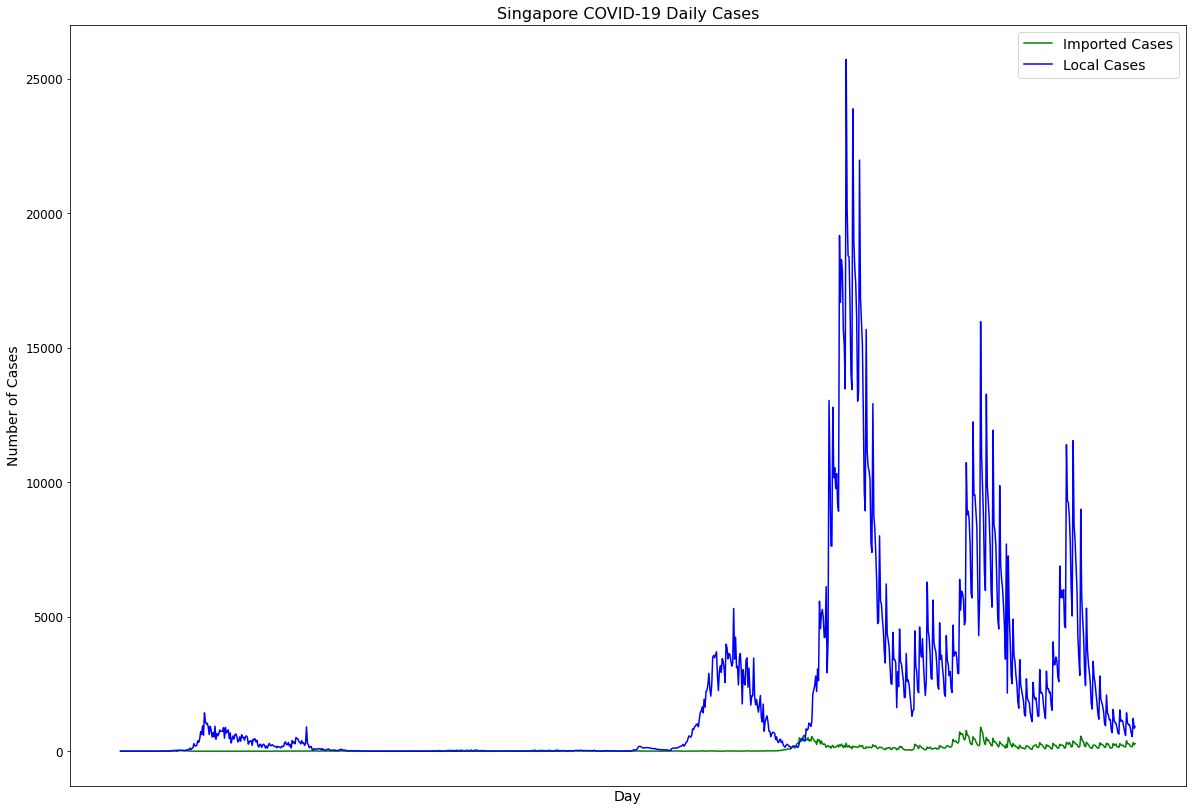

In [8]:
plt.figure(figsize=(20, 14))
plt.plot(importedDF['date'], importedDF['value'], color='g', label='Imported Cases')
plt.plot(localDF['date'], localDF['value'], color='b', label='Local Cases')
plt.title('Singapore COVID-19 Daily Cases', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.xticks([], fontsize=12, rotation = 80)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

Since the local cases are much more significant thant the imported cases, let's combine both local and imported cases.

In [9]:
combinedDict = {'date':[], 'value':[]}
for i in range(0, len(df), 2):
  importedSample = df.iloc[i]
  localSample = df.iloc[i+1]
  combinedDict['date'].append(importedSample['date'])
  combinedDict['value'].append(importedSample['value'] + localSample['value'])
combinedDF = pd.DataFrame(combinedDict)
combinedDF.head()

,date,value
0,2020-01-23,1
1,2020-01-24,2
2,2020-01-25,1
3,2020-01-26,0
4,2020-01-27,1


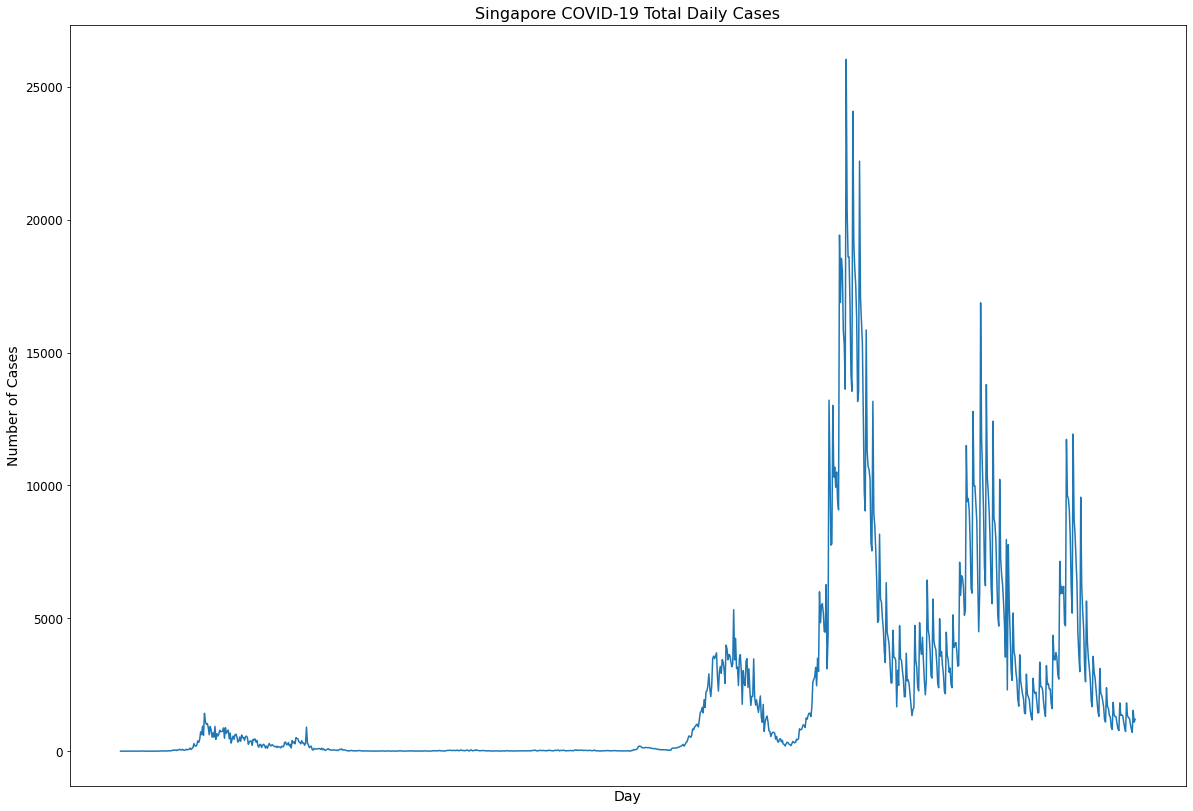

In [10]:
plt.figure(figsize=(20, 14))
plt.plot(combinedDF['date'], combinedDF['value'])
plt.title('Singapore COVID-19 Total Daily Cases', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.xticks([], fontsize=12, rotation = 80)
plt.yticks(fontsize=12)
plt.show()

It is difficult to infer whether there is any trend in the data by inspection. The second half values are much more significant than the first half.

In this project, we will limit our time series between 1st Jan 2022 until 30th Apr 2022. 

In [11]:
combinedDF = combinedDF[(combinedDF['date'] >= pd.to_datetime('2022-01-01')) &
                        (combinedDF['date'] <= pd.to_datetime('2022-04-30'))]
combinedDF = combinedDF.reset_index().drop('index', axis=1)
combinedDF

,date,value
0,2022-01-01,456
1,2022-01-02,429
2,2022-01-03,464
3,2022-01-04,842
4,2022-01-05,805
...,...,...
115,2022-04-26,3688
116,2022-04-27,2646
117,2022-04-28,2690
118,2022-04-29,2517


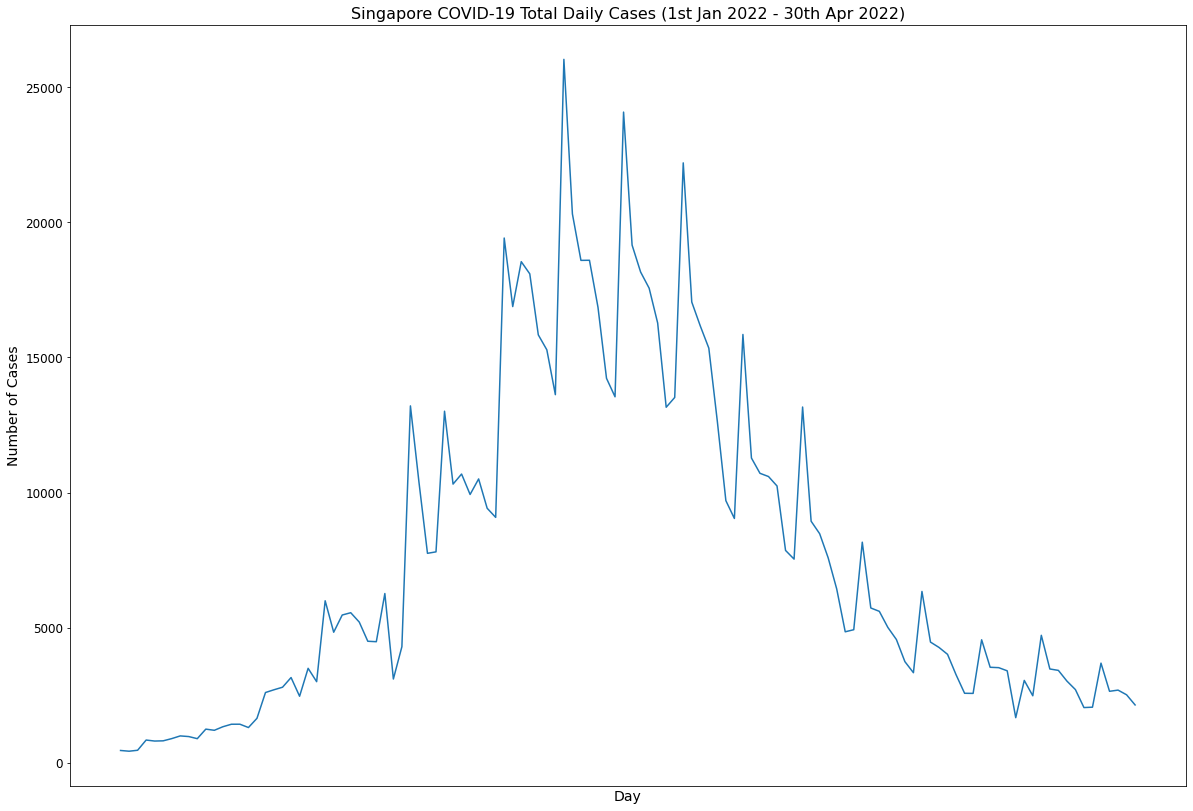

In [12]:
plt.figure(figsize=(20, 14))
plt.plot(combinedDF['date'], combinedDF['value'])
plt.title('Singapore COVID-19 Total Daily Cases (1st Jan 2022 - 30th Apr 2022)', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.xticks([], fontsize=12, rotation = 80)
plt.yticks(fontsize=12)
plt.show()

From the graph, it suggests that there may be a trend, but it is difficult to infer by inspection. There is also seasonality, but the amplitude (height) of the cycles appears to be increasing before it decreases, suggesting that it may be a multiplicative seasonal component. Let's decompose the time series to check whether there is any trend or season in it.<br>
Source: [How to Decompose Time Series Data into Trend and Seasonality](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

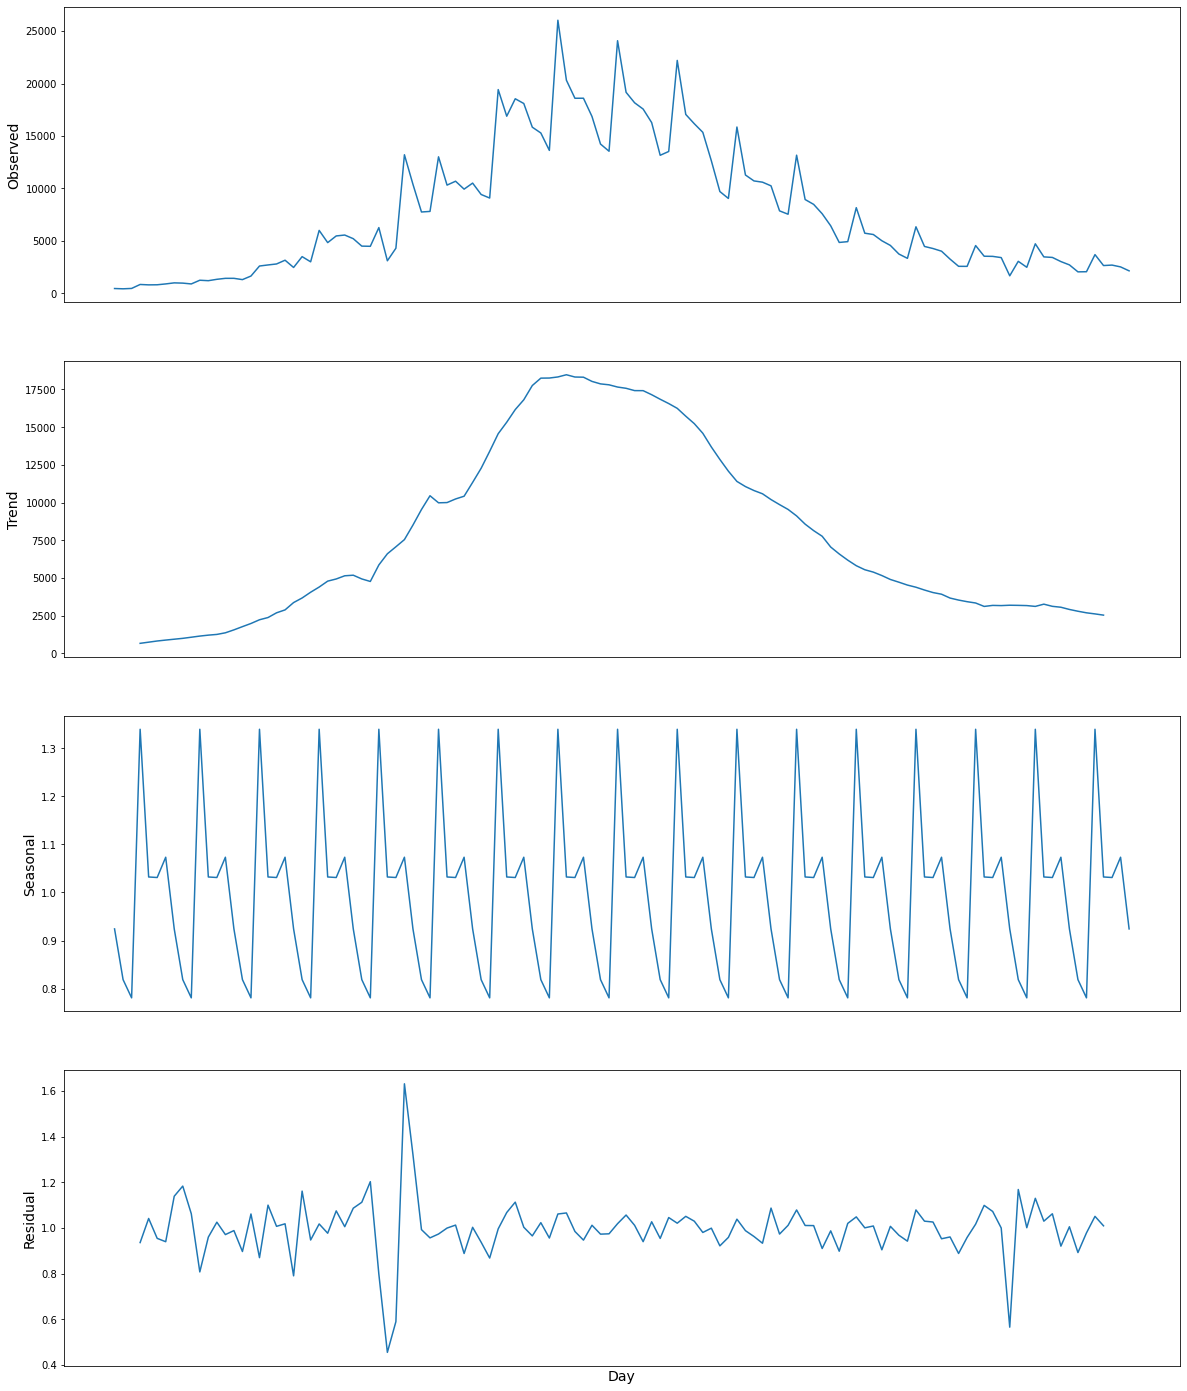

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(combinedDF.set_index('date'), model='multiplicative')
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(20, 25))

ax[0].plot(result.observed)
ax[0].set_ylabel('Observed', fontsize=14)
ax[1].plot(result.trend)
ax[1].set_ylabel('Trend', fontsize=14)
ax[2].plot(result.seasonal)
ax[2].set_ylabel('Seasonal', fontsize=14)
ax[3].plot(result.resid)
ax[3].set_ylabel('Residual', fontsize=14)
plt.xlabel('Day', fontsize=14)
plt.xticks([])
plt.show()

After decomposition, we can see that the time series has a trend and seasonality. The residuals are also interesting, showing periods of high variability in the early time of the series. Next, we will apply transformation to de-trend the data as we want its seasonal pattern.

## Feature Transform

We will apply log transformation on the data. Since the value can be 0, we will add 1 to each value. Here, an important concept arises - stationary. A stationary time series has constant mean, variance, and covariance overtime. Transformation on time series data has the potential to make a time series more stationary. 

* [Stationary and differencing](https://people.duke.edu/~rnau/411diff.htm)
* [How to make a time series stationary](https://analyticsindiamag.com/how-to-make-a-time-series-stationary/)

In [14]:
combinedDF['logValue'] = np.log(combinedDF['value'] + 1)
combinedDF.head()

,date,value,logValue
0,2022-01-01,456,6.124683
1,2022-01-02,429,6.063785
2,2022-01-03,464,6.142037
3,2022-01-04,842,6.736967
4,2022-01-05,805,6.692084


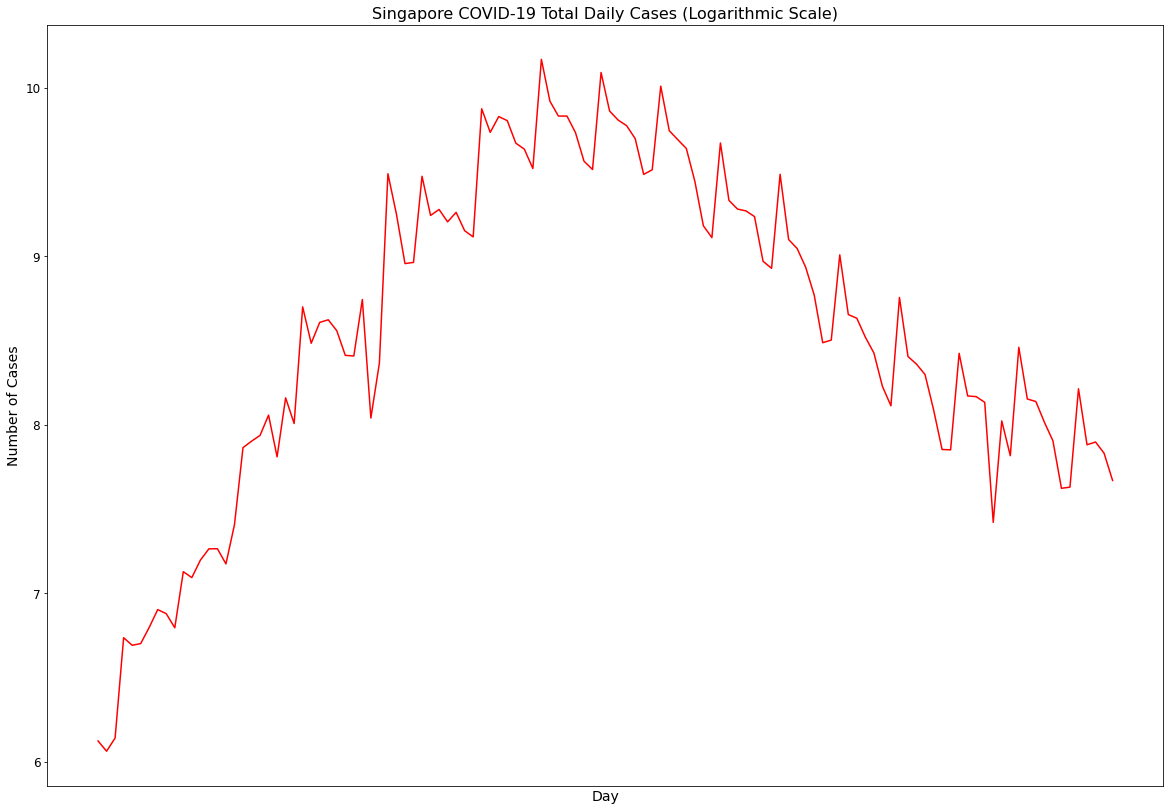

In [15]:
plt.figure(figsize=(20, 14))
plt.plot(combinedDF['date'], combinedDF['logValue'], color='r')
plt.title('Singapore COVID-19 Total Daily Cases (Logarithmic Scale)', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.xticks([], fontsize=12, rotation = 80)
plt.yticks(fontsize=12)
plt.show()

## ARIMA Model

To build an ARIMA model, we need the following parameters:
* The order of differencing, d
* The order of the AR term, p
* The order of the MA term, q

### The order of differencing (d)

First and foremost, the series needs differencing if it is non-stationary. For this purpose, we will use the Augmented Dickey Fuller test in the <code>statsmodels</code>.

The ADF test<br>
H<sub>0</sub>: The time series is non-stationary.<br>
H<sub>1</sub>: The time series is stationary.<br>
The null hypothesis will be rejected if the test statistic is greater than the critical value at a significance level.

In [16]:
result = adfuller(combinedDF['logValue'])
print(f'ADF test')
print(f'Test statistic: {result[0]:.4f}')
print(f'p-value       : {result[1]:.4f}')
print(f'Critical values:')
for key, value in result[4].items():
     print(f'{key}: {value:.4f}')

ADF test
Test statistic: -1.5014
p-value       : 0.5328
Critical values:
1%: -3.4907
5%: -2.8880
10%: -2.5809


We see that the test-statistic is greater than (less negative) all critical values for 1%, 5%, and 10% significance level. We do not reject the null hypothesis and the time series is non-stationary.

Initially, we will try to difference it up to 2 times. We will also plot the auto-correlation function plot (ACF) to visualise it.<br>
Source: [ACF and PACF plots](https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8)

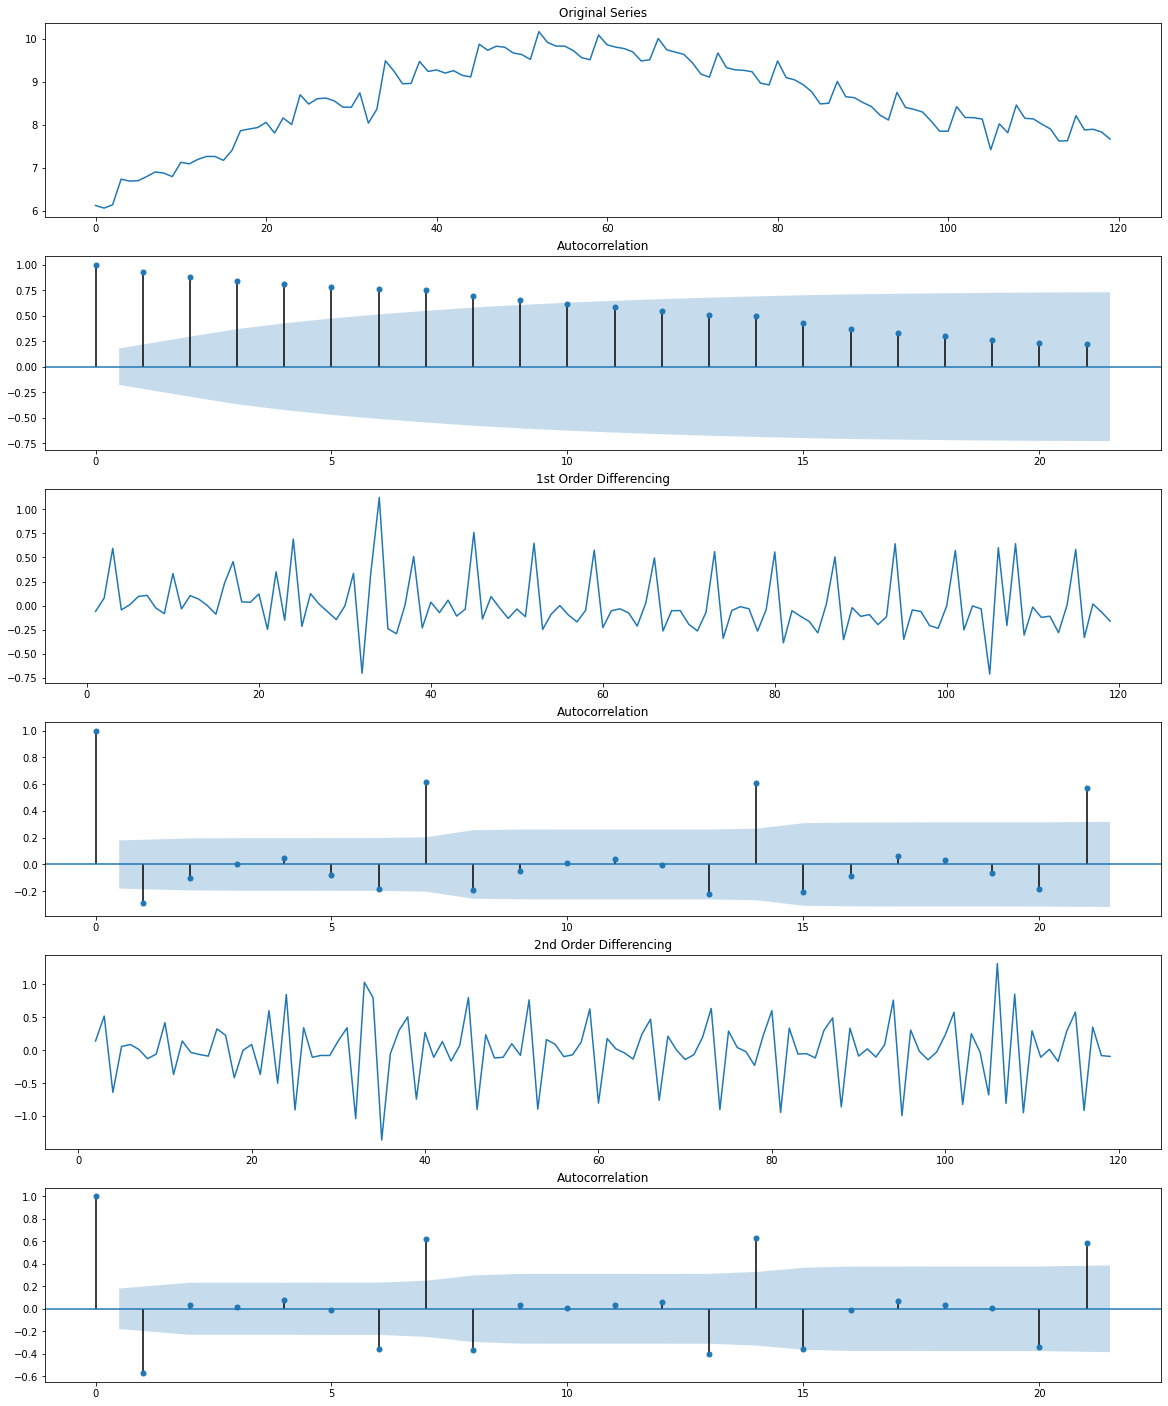

In [17]:
fig, ax = plt.subplots(6, 1, figsize=(20, 25))

# Original Series
ax[0].plot(combinedDF['logValue'])
ax[0].set_title('Original Series')
plot_acf(combinedDF['logValue'], ax=ax[1]); # Semicolon at the end to prevent double display

# 1st Differencing
ax[2].plot(combinedDF['logValue'].diff()); 
ax[2].set_title('1st Order Differencing')
plot_acf(combinedDF['logValue'].diff().dropna(), ax=ax[3]); # Semicolon at the end to prevent double display

# 2nd Differencing
ax[4].plot(combinedDF['logValue'].diff().diff()); 
ax[4].set_title('2nd Order Differencing')
plot_acf(combinedDF['logValue'].diff().diff().dropna(), ax=ax[5]); # Semicolon at the end to prevent double display

The series seems to reach stationarity with one order of differencing. Normally, if the lag-1 autocorrelation is zero or even negative, then the series does not need further differencing. For second-order differencing, the lag-1 autocorrelation is more negative than -0.5 (and theoretically a negative lag-1 autocorrelation should never be greater than 0.5 in magnitude), this may mean the series has been overdifferenced. Our initial guess here is to use d = 1. Let's check again with ADF test.<br>
Source: [Identifying the order of differencing in an ARIMA model](https://people.duke.edu/~rnau/411arim2.htm)

In [18]:
result = adfuller(combinedDF['logValue'].diff().dropna())
print(f'First differencing')
print(f'Test statistic: {result[0]:.4f}')
print(f'p-value       : {result[1]:.4f}')
print(f'Critical values:')
for key, value in result[4].items():
     print(f'{key}: {value:.4f}')
print()
result = adfuller(combinedDF['logValue'].diff().diff().dropna())
print(f'Second differencing')
print(f'Test statistic: {result[0]:.4f}')
print(f'p-value       : {result[1]:.4f}')
print(f'Critical values:')
for key, value in result[4].items():
     print(f'{key}: {value:.4f}')

First differencing
Test statistic: -1.2538
p-value       : 0.6501
Critical values:
1%: -3.4942
5%: -2.8895
10%: -2.5817

Second differencing
Test statistic: -6.9270
p-value       : 0.0000
Critical values:
1%: -3.4942
5%: -2.8895
10%: -2.5817


That is quite a surprise, we see the time series is still non-stationary for first differencing. Let's use second order differencing which is overdifferenced.
To balance this effect, after we have determined the MA term, we will increase it by 1.<br>
Source: [Identifying the numbers of AR or MA terms in an ARIMA model](https://people.duke.edu/~rnau/411arim3.htm).

### The order of the AR term (p)

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. This allows us to know whether a certain lag is required in the AR term.

Any autocorrelation in a stationarised series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

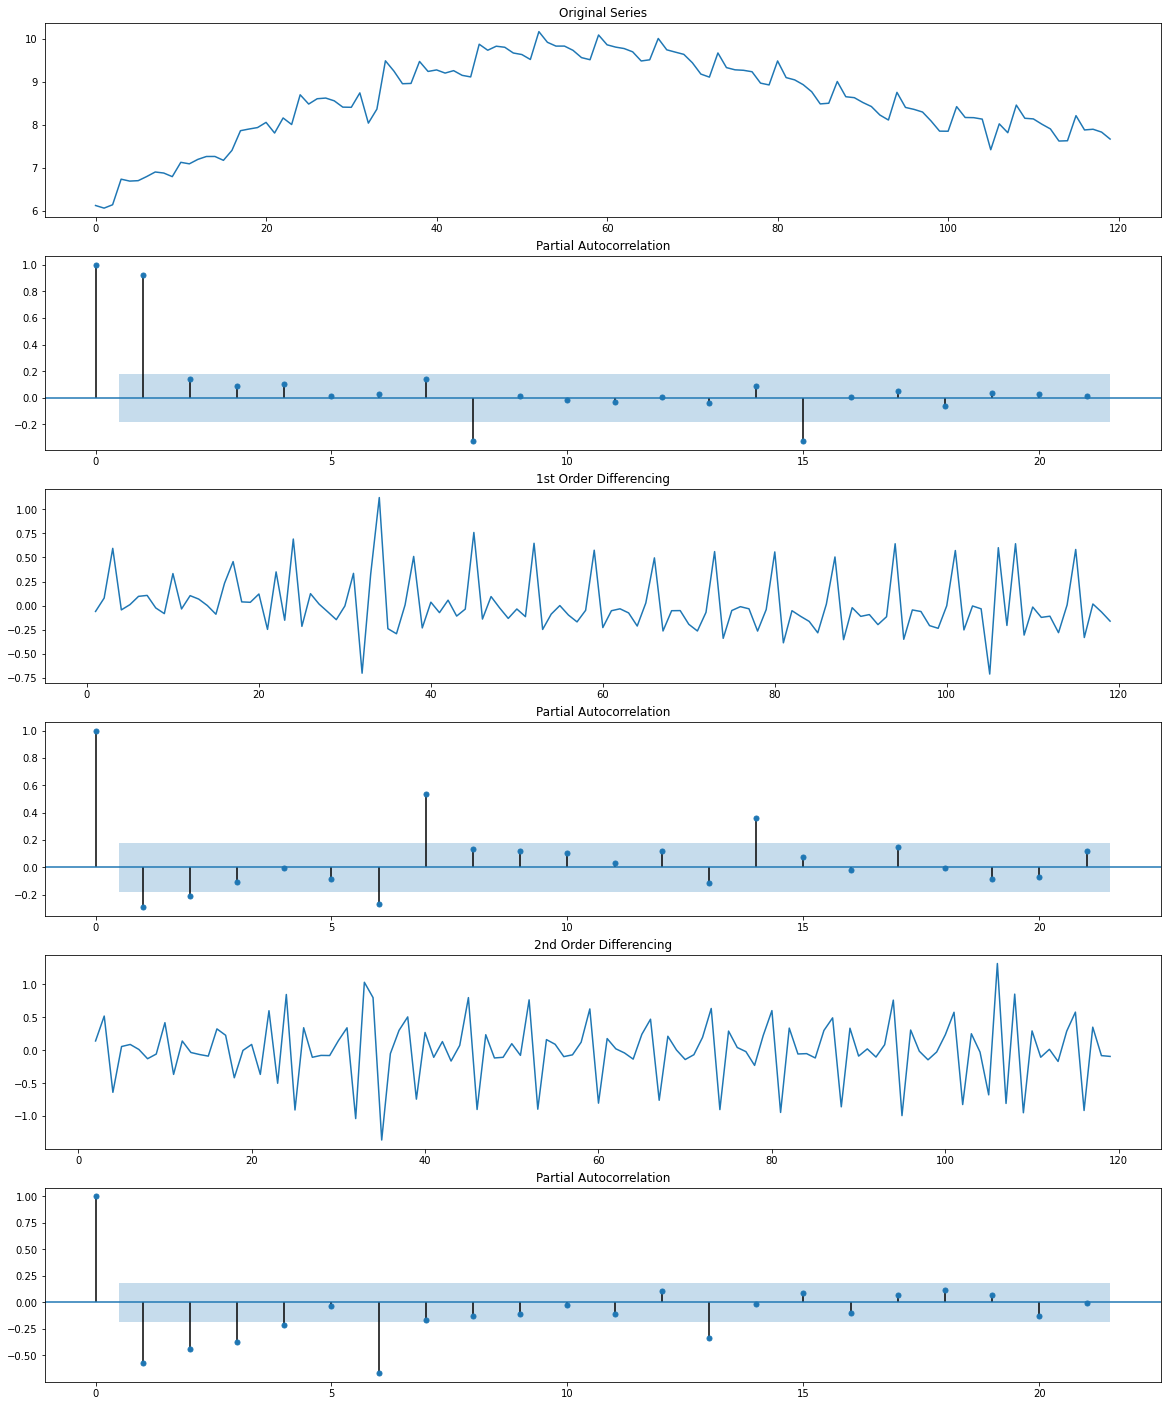

In [19]:
fig, ax = plt.subplots(6, 1, figsize=(20, 25))

# Original series
ax[0].plot(combinedDF['logValue']); 
ax[0].set_title('Original Series')
plot_pacf(combinedDF['logValue'], ax=ax[1], method='ywm'); # Semicolon at the end to prevent double display

# 1st difference
ax[2].plot(combinedDF['logValue'].diff()); 
ax[2].set_title('1st Order Differencing')
plot_pacf(combinedDF['logValue'].diff().dropna(), ax=ax[3], method='ywm'); # Semicolon at the end to prevent double display

# 2nd difference
ax[4].plot(combinedDF['logValue'].diff().diff()); 
ax[4].set_title('2nd Order Differencing')
plot_pacf(combinedDF['logValue'].diff().diff().dropna(), ax=ax[5], method='ywm'); # Semicolon at the end to prevent double display

Based on the PACF plot of the original series, we see that it displays a sharp cutoff after lag 1. So, we will guess AR(1).

### The order of the MA term (q)

An MA term is technically, the error of the lagged forecast. We can look at the ACF for the number of MA terms. 

The ACF tells us how many MA terms are required to remove any autocorrelation in the stationarised series.

Again, we look at the original series' ACF plot.

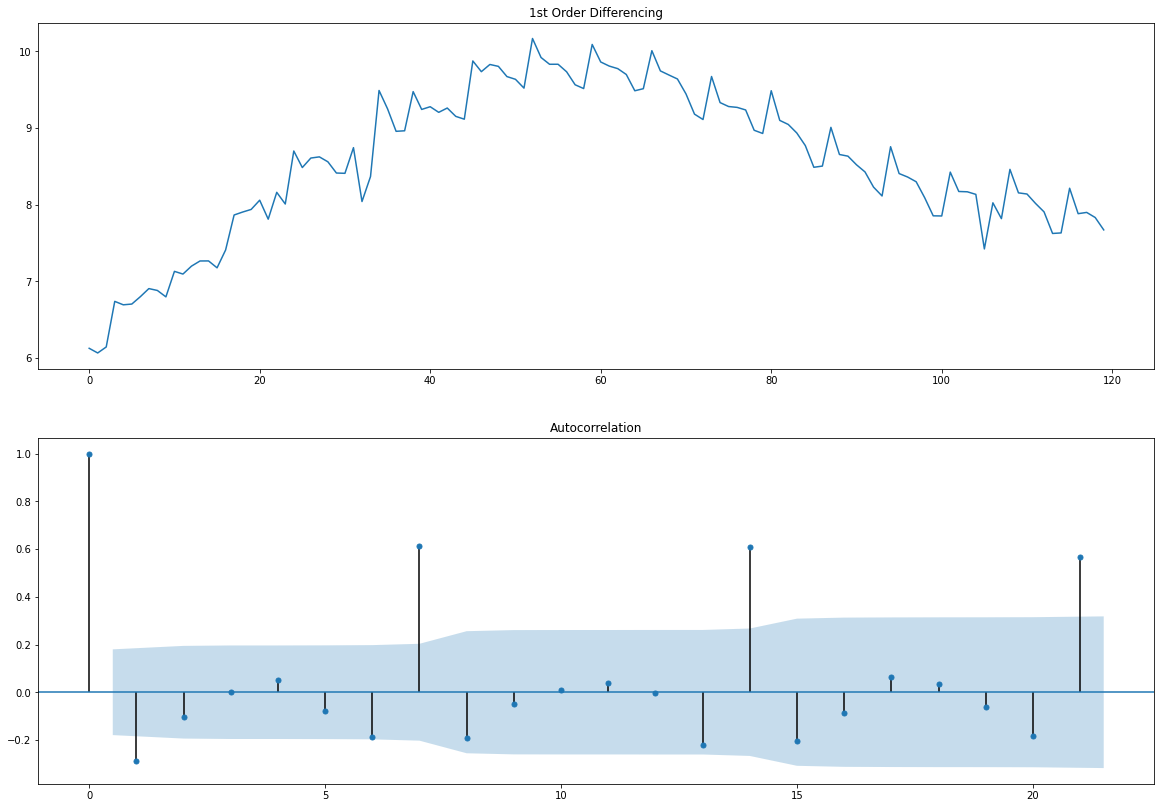

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

# 1st difference
ax[0].plot(combinedDF['logValue']); 
ax[0].set_title('1st Order Differencing')
plot_acf(combinedDF['logValue'].diff().dropna(), ax=ax[1]); # Semicolon at the end to prevent double display

We see that the ACF of the 1st order differencing shows a negative lag-1 correlation. So, we will guess MA term to be 1. Since we use 2nd order differencing which is overdifferenced. We will add 1 to the MA term. Hence, we will use MA(2).

### Model Training

We have obtained the order of difference to be 2, the order of AR term to be 1, and the order of the MA term to be 2 (1 + 1).

In [21]:
from statsmodels.tsa.arima.model import ARIMA

# 2, 1, 2 ARIMA Model
model = ARIMA(combinedDF['logValue'], order=(2, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               logValue   No. Observations:                  120
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -16.274
Date:                Fri, 23 Dec 2022   AIC                             42.547
Time:                        03:59:18   BIC                             56.443
Sample:                             0   HQIC                            48.190
                                - 120                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7487      0.294     -2.545      0.011      -1.325      -0.172
ar.L2          0.0229      0.321      0.071      0.943      -0.607       0.653
ma.L1          0.3977      0.270      1.474      0.1

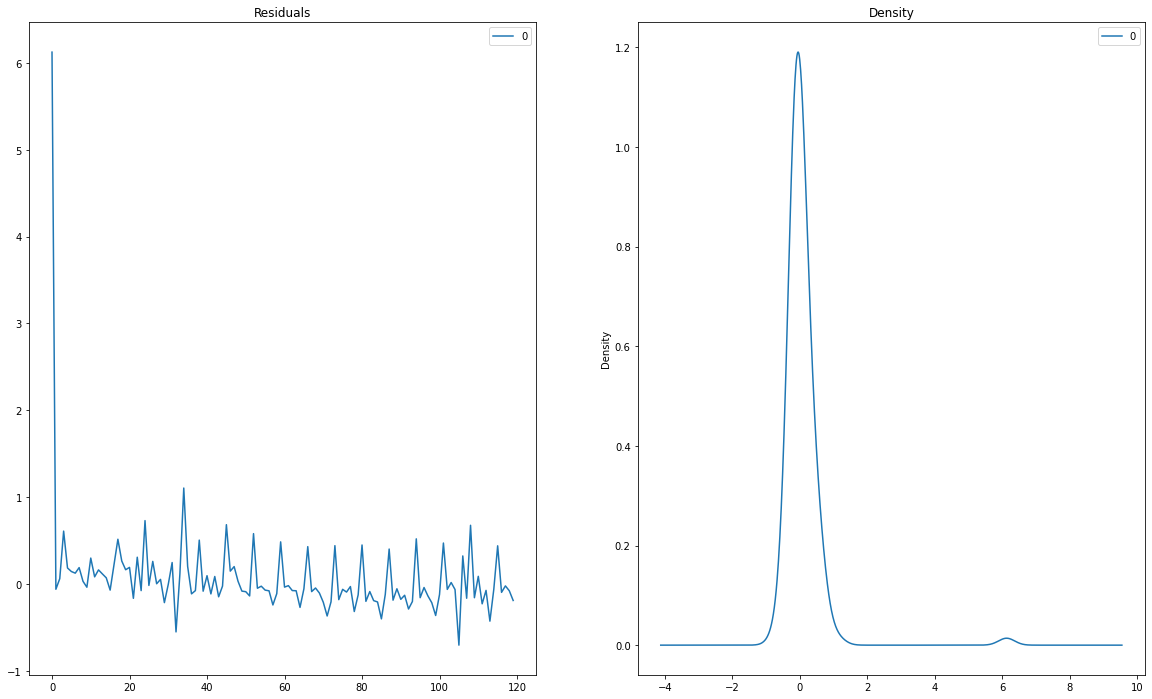

In [22]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(20, 12))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [23]:
residuals.describe()

,0
count,120.000000
mean,0.075151
std,0.621595
min,-0.704501
25%,-0.131805
50%,-0.055580
75%,0.162547
max,6.124683


The residual errors look uniform with near zero mean and uniform variance. Let’s plot the actuals against the fitted values.

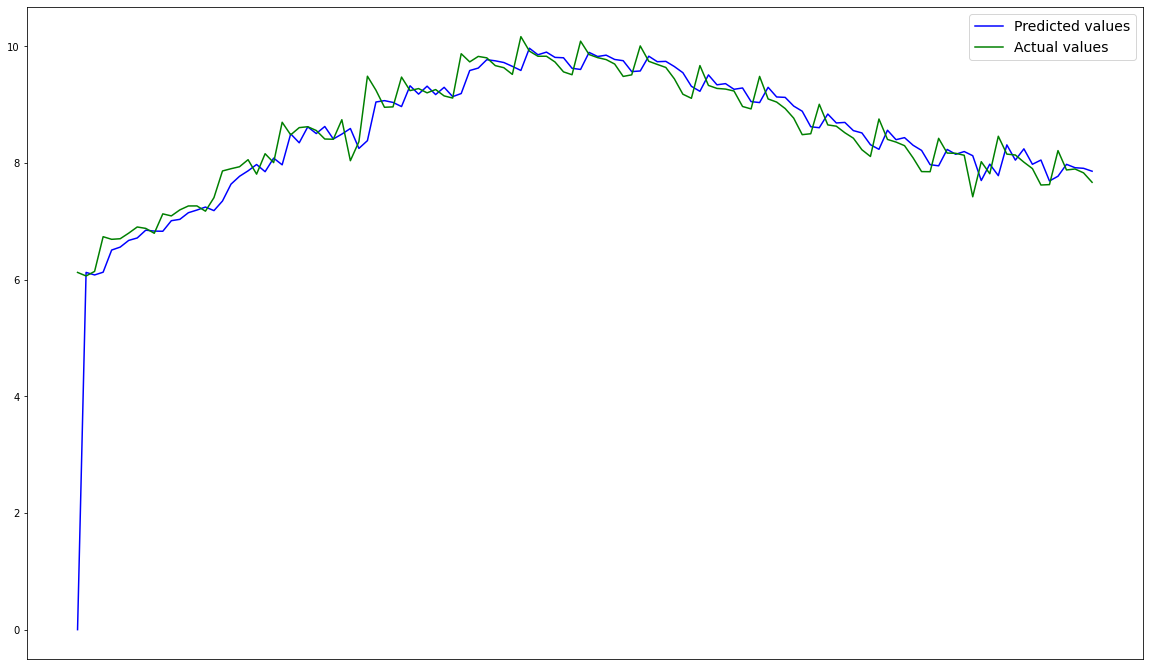

In [24]:
# Actual vs Fitted

plt.figure(figsize=(20, 12))
plt.plot(combinedDF['date'], model_fit.predict(dynamic=False), label='Predicted values', color='b')
plt.plot(combinedDF['date'], combinedDF['logValue'], label='Actual values', color='g')
plt.xticks([])
plt.legend(fontsize=14)
plt.show()

We can see the pattern of the forecast values is around the actual values. However, it might have underfitted.

### Out of Time Cross Validation

Let's check the performance of the model using OOT cross validation. In Out-of-Time cross-validation, you take few steps back in time and forecast into the future to as many steps you took back. Then you compare the forecast against the actuals.

First, we will split the dataset into 90/10.

In [25]:
ratio = 0.9
# Create Training and Test
train = combinedDF['logValue'][:int(len(combinedDF)*ratio)]
test = combinedDF['logValue'][int(len(combinedDF)*ratio):]

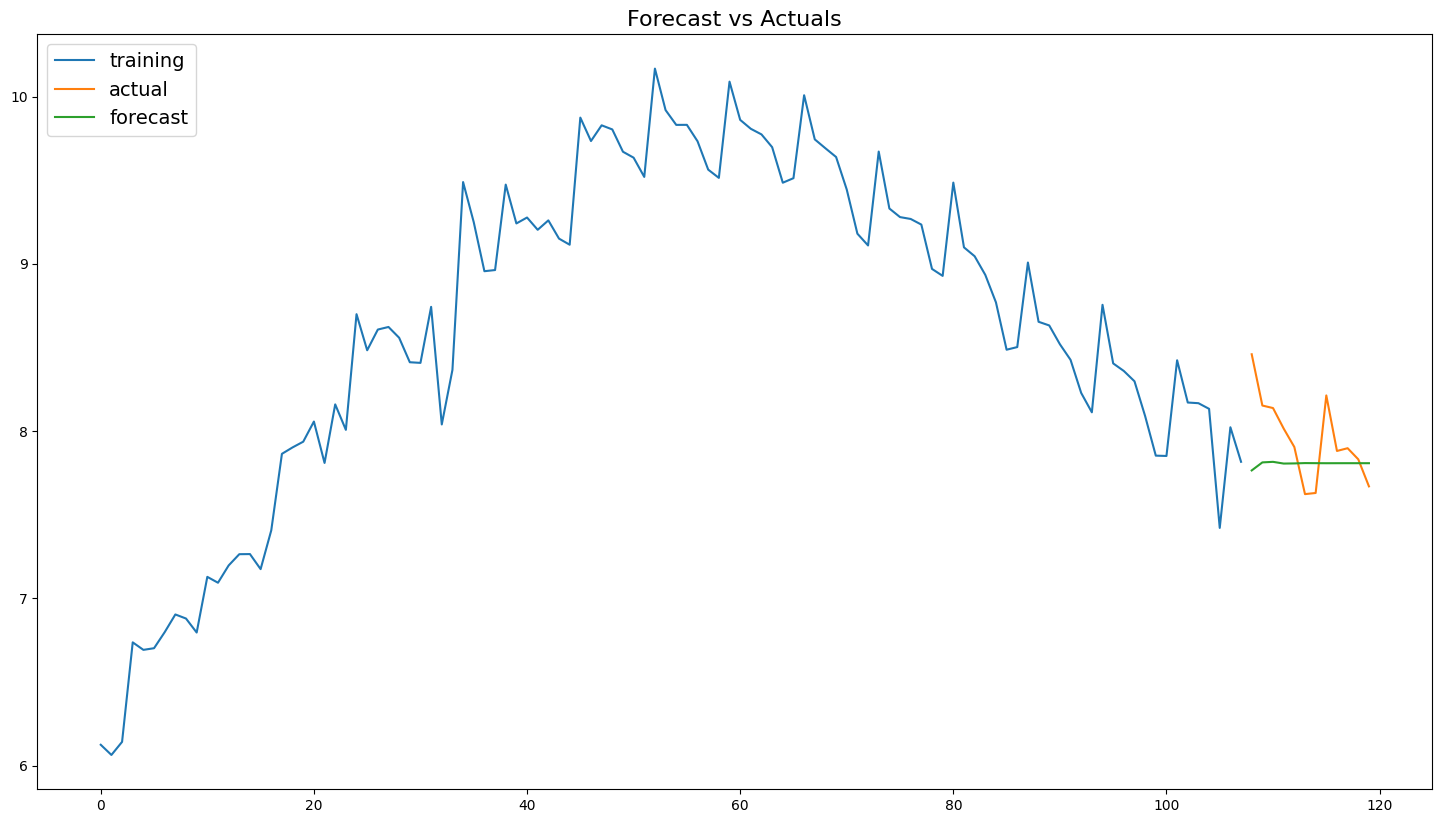

In [26]:
model = ARIMA(train, order=(2, 1, 2))  
fitted = model.fit()  

# Forecast
fc_series = fitted.forecast(len(combinedDF) - int(len(combinedDF)*ratio))

# Plot
plt.figure(figsize=(18,10), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals', fontsize=16)
plt.legend(loc='upper left', fontsize=14)
plt.show()

From the graph, the ARIMA(2, 1, 2) model does not perform well enough. Most of the predicted forecasts is below the actuals. That means, by adding a small constant to our forecast, the accuracy will certainly improve. So, there is definitely scope for improvement.

### Parameter Tuning

Akaike’s Information Criterion (AIC), is useful for determining the order of an ARIMA model.<br>
Source: [Estimation and order selection](https://otexts.com/fpp2/arima-estimation.html)

We will iteratively set both p and q from 0 to 5 to see which model gives least AIC and also look for a graph that gives closer actuals and forecasts. Then, we will increase d by 1 and reiterate through p and q again.

                               SARIMAX Results                                
Dep. Variable:               logValue   No. Observations:                  108
Model:                 ARIMA(3, 2, 1)   Log Likelihood                 -13.495
Date:                Fri, 23 Dec 2022   AIC                             36.991
Time:                        03:59:20   BIC                             50.308
Sample:                             0   HQIC                            42.388
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4626      0.161     -2.873      0.004      -0.778      -0.147
ar.L2         -0.3878      0.184     -2.106      0.035      -0.749      -0.027
ar.L3         -0.1605      0.168     -0.956      0.3

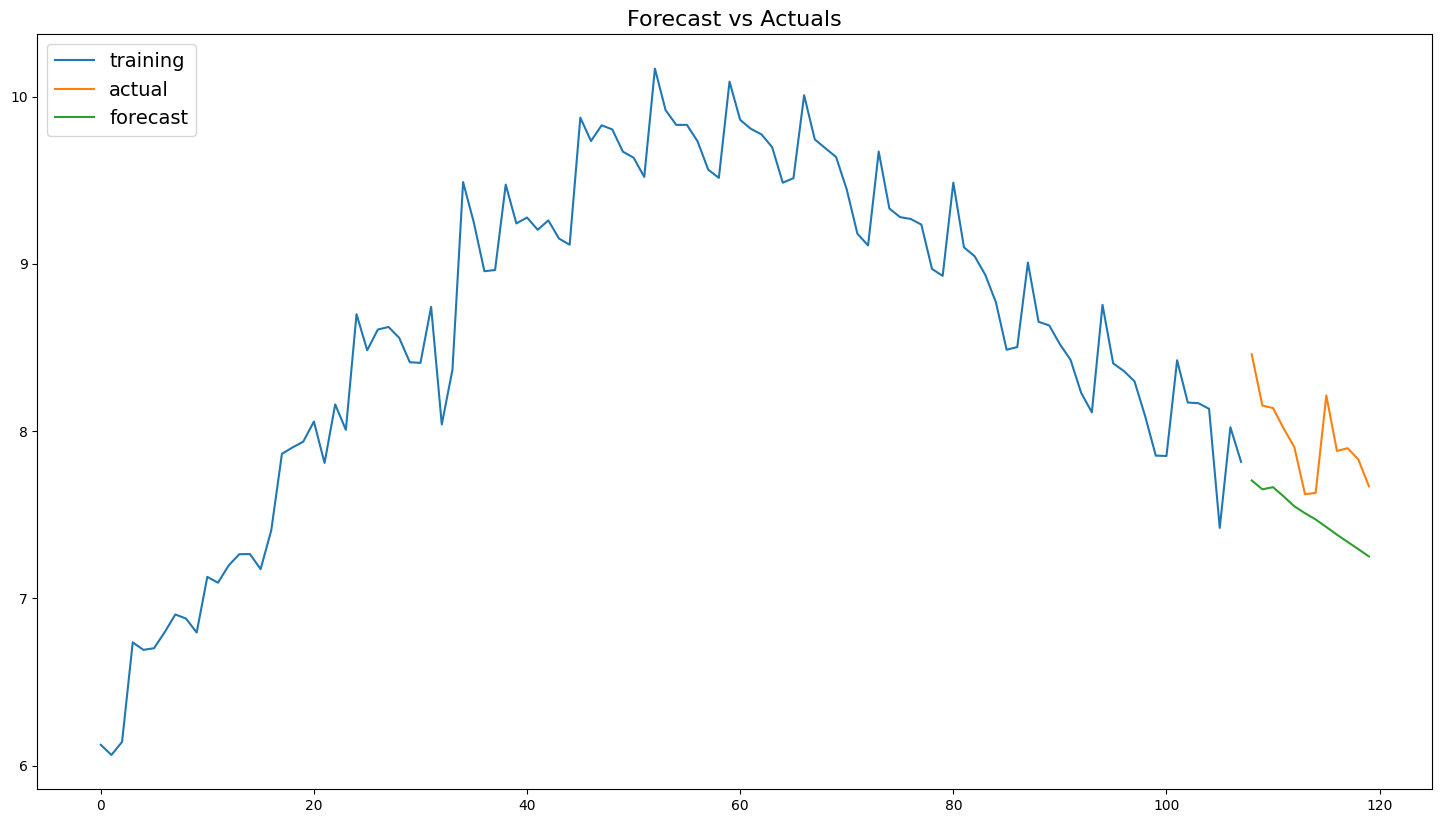

In [27]:
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc_series = fitted.forecast(len(combinedDF) - int(len(combinedDF)*ratio))

# Plot
plt.figure(figsize=(18, 10), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals', fontsize=16)
plt.legend(loc='upper left', fontsize=14)
plt.show()

The AIC has reduced to 36.991 from 42.547. Hence, ARIMA(3, 2, 1) might be a better model than ARIMA(2, 1, 2) in this case.

### Accuracy Metrics

We will use the common accuracy metrics to evaluate forecasting models:
* Mean Absolute Percentage Error (MAPE)
* Mean Absolute Error (MAE)
* Root Mean Squared Error (RMSE)
* Correlation between the Actual and the Forecast (Corr)
* Lag 1 Autocorrelation of Error (ACF1)

In [28]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))                  # MAE
    rmse = np.mean((forecast - actual)**2)**.5                # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]                 # Corr
    acf1 = acf(forecast-test, nlags=1, fft=True)[1]           # ACF1
    return({'MAPE':mape, 'MAE': mae, 
            'RMSE':rmse, 'Corr':corr, 'ACF1':acf1})

metrics = forecast_accuracy(fc_series.to_numpy(), test.values)
for i in metrics:
  print(f'{i}: {metrics[i]}')

MAPE: 0.05777842027751718
MAE: 0.4636863474079132
RMSE: 0.5016085957172188
Corr: 0.6256260437267693
ACF1: 0.18820086447522585


Around 5.78% MAPE implies the model is about 94.22% accurate in predicting the next 12 observations.